In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import matplotlib.dates as mdates
from datetime import datetime, timedelta
pd.set_option('display.max_rows', 500)

In [2]:
confirmed_df = pd.read_csv(r'../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
confirmed_df.rename(columns={'Province/State': 'Province_State', 'Country/Region': 'Country_Region'}, inplace=True)
confirmed_df.head()

,Province_State,Country_Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,59,70,75,82,114,147,177,212,272,322
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,639,639,701,773,839,825,878,889,924,963
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,178,178,200,212,226,243,266,313,345,385
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,149,149,197,238,428,566,673,790,900,1030


In [3]:
def create_df(a_series):
    dates = a_series.index[4:].values
    counts = a_series.values[4:]
    df = pd.DataFrame({'date': dates, 'count': counts})
    df['Province_State'] = a_series['Province_State'] 
    df['Country_Region'] = a_series['Country_Region'] 
    df['Lat'] = a_series['Lat'] 
    df['Long'] = a_series['Long'] 
    return df

In [4]:
confirmed_df_2 = pd.concat(confirmed_df.apply(create_df, axis=1).values).set_index(['Country_Region', 'Province_State', 'Lat', 'Long'])
confirmed_df_2['date'] = pd.to_datetime(confirmed_df_2['date'])
confirmed_df_2.head()

date count
Country_Region Province_State Lat  Long                  
Thailand       NaN            15.0 101.0 2020-01-22     2
                                   101.0 2020-01-23     3
                                   101.0 2020-01-24     5
                                   101.0 2020-01-25     7
                                   101.0 2020-01-26     8

In [22]:
# country_df = confirmed_df_2.query('Country_Region == "Israel"')
# country_df = confirmed_df_2.query('Country_Region == "Spain"')
country_df = confirmed_df_2.query('Country_Region == "Italy"')
country_df.tail()

date  count
Country_Region Province_State Lat  Long                  
Italy          NaN            43.0 12.0 2020-03-16  27980
                                   12.0 2020-03-17  31506
                                   12.0 2020-03-18  35713
                                   12.0 2020-03-19  41035
                                   12.0 2020-03-20  47021

In [23]:
last_date = country_df['date'].iloc[-1]
last_date

Timestamp('2020-03-20 00:00:00')

In [24]:
values = list(country_df.index[0]) + [last_date + timedelta(days=1), 887]
values

['Italy', nan, 43.0, 12.0, Timestamp('2020-03-21 00:00:00'), 887]

In [25]:
columns = list(country_df.index.names) + country_df.columns.tolist()
columns

['Country_Region', 'Province_State', 'Lat', 'Long', 'date', 'count']

In [26]:
values = list(country_df.index[0]) + [last_date + timedelta(days=1), 887]
columns = list(country_df.index.names) + country_df.columns.tolist()
values, columns
row_df = pd.DataFrame([values], columns=columns).set_index(country_df.index.names)
row_df

,,,,date,count
Country_Region,Province_State,Lat,Long,,
Italy,NaN,43.0,12.0,2020-03-21,887


In [27]:
# country_updated_df = country_df.append(row_df)
# country_updated_df.tail()
country_updated_df = country_df

<IPython.core.display.Javascript object>


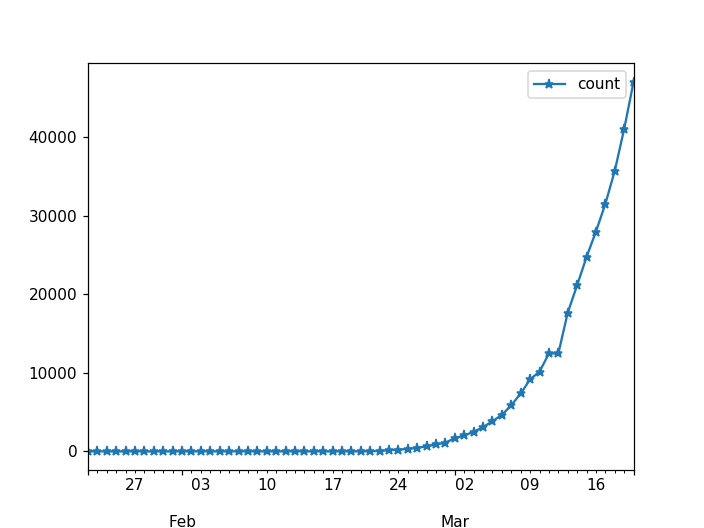

In [28]:
%matplotlib notebook
country_updated_df.plot(x='date', y='count', marker='*')

In [29]:
def exponential(x, a, k, b):
    return a*np.exp(x*k) + b

In [30]:
non_zero_country_df = country_updated_df[country_updated_df['count'] > 0]
y_array_exp = non_zero_country_df['count'].values
ref_date = datetime(2020, 1, 1)
x_array = (non_zero_country_df['date'] - ref_date).dt.days.values.astype(float)

In [31]:
last_model_date = country_updated_df['date'].iloc[-1]
# last_model_date = datetime(2020, 3, 18)
last_model_index = np.argmin((non_zero_country_df['date'] - last_model_date).abs().values)
last_model_index

49

In [32]:
popt_exponential, pcov_exponential = scipy.optimize.curve_fit(exponential, x_array[:last_model_index], y_array_exp[:last_model_index], p0=
(0.0021819439144763727, 0.2196989290489097, -0.8576298838011189))
a, k, b = popt_exponential
a, k, b, np.exp(k), np.exp(k*7)

(0.2706273872886846,
 0.15355158204959007,
 -472.61183222926854,
 1.1659679285865017,
 2.929585877630708)

In [33]:
estimated = exponential(x_array, a, k, b)
non_zero_country_df['estimated'] = estimated
estimated

/home/erez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([-4.45511795e+02, -4.41014058e+02, -4.35769841e+02, -4.29655252e+02,
       -4.22525837e+02, -4.14213168e+02, -4.04520863e+02, -3.93219946e+02,
       -3.80043439e+02, -3.64680054e+02, -3.46766841e+02, -3.25880608e+02,
       -3.01527931e+02, -2.73133490e+02, -2.40026483e+02, -2.01424774e+02,
       -1.56416420e+02, -1.03938122e+02, -4.27501105e+01,  2.85931490e+01,
        1.11777102e+02,  2.08766922e+02,  3.21853943e+02,  4.53709782e+02,
        6.07449461e+02,  7.86704997e+02,  9.95711203e+02,  1.23940574e+03,
        1.52354574e+03,  1.85484388e+03,  2.24112689e+03,  2.69152048e+03,
        3.21666497e+03,  3.82896659e+03,  4.54289066e+03,  5.37530321e+03,
        6.34586956e+03,  7.47751879e+03,  8.79698551e+03,  1.03354414e+04,
        1.21292316e+04,  1.42207334e+04,  1.66593575e+04,  1.95027150e+04,
        2.28179786e+04,  2.66834696e+04,  3.11905082e+04,  3.64455707e+04,
        4.25728049e+04,  4.97169636e+04])

<IPython.core.display.Javascript object>


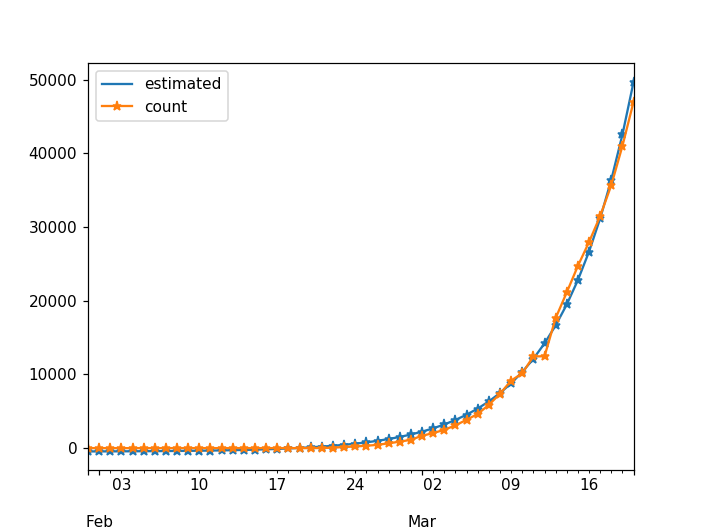

In [34]:
plt.figure()
ax = plt.gca()
non_zero_country_df.plot(ax=ax, x='date', y='estimated' ,marker='*')
non_zero_country_df.plot(ax=ax, x='date', y='count' ,marker='*')
plt.show()

In [20]:
non_zero_country_df

date  count     estimated
Country_Region Province_State Lat  Long                                
Spain          NaN            40.0 -4.0 2020-02-01      1   -117.628460
                                   -4.0 2020-02-02      1   -117.545382
                                   -4.0 2020-02-03      1   -117.440454
                                   -4.0 2020-02-04      1   -117.307928
                                   -4.0 2020-02-05      1   -117.140546
                                   -4.0 2020-02-06      1   -116.929139
                                   -4.0 2020-02-07      1   -116.662129
                                   -4.0 2020-02-08      1   -116.324891
                                   -4.0 2020-02-09      2   -115.898953
                                   -4.0 2020-02-10      2   -115.360986
                                   -4.0 2020-02-11      2   -114.681526
                                   -4.0 2020-02-12      2   -113.823356
                                   -4.0 2020-02-13      2   -112.739473
                                   -4.0 2020-02-14      2   -111.370510
                                   -4.0 2020-02-15      2   -109.641488
                                   -4.0 2020-02-16      2   -107.457704
                                   -4.0 2020-02-17      2   -104.699548
                                   -4.0 2020-02-18      2   -101.215952
                                   -4.0 2020-02-19      2    -96.816111
                                   -4.0 2020-02-20      2    -91.259039
                                   -4.0 2020-02-21      2    -84.240365
                                   -4.0 2020-02-22      2    -75.375662
                                   -4.0 2020-02-23      2    -64.179395
                                   -4.0 2020-02-24      2    -50.038323
                                   -4.0 2020-02-25      6    -32.177913
                                   -4.0 2020-02-26     13     -9.619917
                                   -4.0 2020-02-27     15     18.871207
                                   -4.0 2020-02-28     32     54.855971
                                   -4.0 2020-02-29     45    100.305328
                                   -4.0 2020-03-01     84    157.708624
                                   -4.0 2020-03-02    120    230.209943
                                   -4.0 2020-03-03    165    321.780318
                                   -4.0 2020-03-04    222    437.435227
                                   -4.0 2020-03-05    259    583.509304
                                   -4.0 2020-03-06    400    768.003299
                                   -4.0 2020-03-07    500   1001.022289
                                   -4.0 2020-03-08    673   1295.329157
                                   -4.0 2020-03-09   1073   1667.043636
                                   -4.0 2020-03-10   1695   2136.525218
                                   -4.0 2020-03-11   2277   2729.488281
                                   -4.0 2020-03-12   2277   3478.410512
                                   -4.0 2020-03-13   5232   4424.311771
                                   -4.0 2020-03-14   6391   5619.000825
                                   -4.0 2020-03-15   7798   7127.913012
                                   -4.0 2020-03-16   9942   9033.694252
                                   -4.0 2020-03-17  11748  11440.727721
                                   -4.0 2020-03-18  13910  14480.851107
                                   -4.0 2020-03-19  17963  18320.577612
                                   -4.0 2020-03-20  20410  23170.216180

In [21]:
extrapolation_dates_series = pd.Series([last_model_date + timedelta(days=k) for k in range(1, 14)])
extrapolation_x_array = (extrapolation_dates_series - ref_date).dt.days.values.astype(float)
extrapolation_estimated = exponential(extrapolation_x_array, a, k, b)
extrapolation_df = pd.DataFrame({'date': extrapolation_dates_series, 'estimated': extrapolation_estimated})
extrapolation_df

,date,estimated
0,2020-03-21,29295.390517
1,2020-03-22,37031.587789
2,2020-03-23,46802.533875
3,2020-03-24,59143.401627
4,2020-03-25,74730.123272
5,2020-03-26,94416.412482
6,2020-03-27,119280.523848
7,2020-03-28,150684.310895
8,2020-03-29,190347.817316
9,2020-03-30,240443.486965


In [ ]:
plt.figure()
ax = plt.gca()
non_zero_country_df.plot(ax=ax, x='date', y='estimated' ,marker='*')
non_zero_country_df.plot(ax=ax, x='date', y='count' ,marker='*')
extrapolation_df.plot(ax=ax, x='date', y='estimated' ,marker='o')
plt.show()

In [ ]:
# %matplotlib notebook
# plt.figure(figsize=(9, 8))
# for iteration in range(0, 8):
#     plt.subplot(331 + iteration)
#     n_days = int(iteration * 7)
#     x_long_term = range(len(y_array_exp) + n_days)
#     y_forecast = exponential(x_long_term, a, k, b)
#     max_val = y_forecast.max() 
#     plt.plot(estimated)
#     plt.plot(y_array_exp, '--*')
#     plt.plot(y_forecast, '--b')
#     plt.title(f'weeks from now: {iteration}\ncases:{int(max_val):,}', y=.5)